In [ ]:
options(repr.matrix.max.cols=500)
options(warn=-1)
install.packages(c("caret", "class", "rpart", "rpart.plot", "randomForest", "xgboost", "MLmetrics", "caTools", "NeuralNetTools", "skimr"))
library(caret)
library(class)
library(rpart)
library(rpart.plot)
library(randomForest)
library(xgboost)
library(MLmetrics)
library(tidyverse)
library(reshape2)
library(caTools)
library(NeuralNetTools)
library(skimr)

# **Regression Problem: Predicting a Car's Price**

Data taken from the [Kaggle competition here](https://www.kaggle.com/datasets/avikasliwal/used-cars-price-prediction). 

##Read in the Data

In [ ]:
# Read in data
data <- read_csv("http://www.dsm.business/data/car_price_data.csv")
data <- data[,-c(1, 13)] # Remove unnecessary columns

# Convert select columns to numeric
data$Mileage <- parse_number(data$Mileage)
data$Engine <- parse_number(data$Engine)
data$Power <- parse_number(data$Power)

data$Price <- log(data$Price)

# Extract the manufacturer's name
carMake <- colsplit(data$Name, " ", c("MANUF","MAKE"))
data$Name <- parse_factor(carMake$MANUF)
data$Fuel_CNG = ifelse(data$Fuel_Type == "CNG",1,0)
data$Fuel_Diesel = ifelse(data$Fuel_Type == "Diesel",1,0)
data$Fuel_Electric = ifelse(data$Fuel_Type == "Electric",1,0)
data$Fuel_LPG = ifelse(data$Fuel_Type == "LPG",1,0)
data$Manual = ifelse(data$Transmission=="Manual",1,0)
data$First_Owner =ifelse(data$Owner_Type=="First",1,0)

# View data
head(data)

New names:
• `` -> `...1`
Rows: 6019 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (9): Name, Location, Fuel_Type, Transmission, Owner_Type, Mileage, Engin...
dbl (5): ...1, Year, Kilometers_Driven, Seats, Price

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price,Fuel_CNG,Fuel_Diesel,Fuel_Electric,Fuel_LPG,Manual,First_Owner
<fct>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Maruti,Mumbai,2010,72000,CNG,Manual,First,26.60,998,58.16,5,0.5596158,1,0,0,0,1,1
Hyundai,Pune,2015,41000,Diesel,Manual,First,19.67,1582,126.20,5,2.5257286,0,1,0,0,1,1
Honda,Chennai,2011,46000,Petrol,Manual,First,18.20,1199,88.70,5,1.5040774,0,0,0,0,1,1
Maruti,Chennai,2012,87000,Diesel,Manual,First,20.77,1248,88.76,7,1.7917595,0,1,0,0,1,1
Audi,Coimbatore,2013,40670,Diesel,Automatic,Second,15.20,1968,140.80,5,2.8758220,0,1,0,0,0,0
Hyundai,Hyderabad,2012,75000,LPG,Manual,First,21.10,814,55.20,5,0.8544153,0,0,0,1,1,1


## Exploratory Data Analysis

Spend some time exploring the data. 

In [ ]:
# ADD COMMAND(S) HERE

## Create Dummy Variables

In [ ]:
data = data[,-c(1,2,5,6,7)]
head(data)

Year,Kilometers_Driven,Mileage,Engine,Power,Seats,Price,Fuel_CNG,Fuel_Diesel,Fuel_Electric,Fuel_LPG,Manual,First_Owner
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2010,72000,26.60,998,58.16,5,0.5596158,1,0,0,0,1,1
2015,41000,19.67,1582,126.20,5,2.5257286,0,1,0,0,1,1
2011,46000,18.20,1199,88.70,5,1.5040774,0,0,0,0,1,1
2012,87000,20.77,1248,88.76,7,1.7917595,0,1,0,0,1,1
2013,40670,15.20,1968,140.80,5,2.8758220,0,1,0,0,0,0
2012,75000,21.10,814,55.20,5,0.8544153,0,0,0,1,1,1


##Split into Train/Test

In [ ]:
set.seed(307560)

# Split the data into train (80%) and test (20%) sets
split <- sample.split(data$Price, SplitRatio = 0.8)
train <- filter(data, split == TRUE)
test <- filter(data, split == FALSE)

## Fit a Linear Regression

In [ ]:
# Define the train control object, which establishes the conditions of the cross validation
trctrl <- trainControl(method = "cv", number = 5)

# Fit the lm model using five-fold cross-validation
set.seed(3333)
lm_fit <- train(
        Price ~ ., data = train, method = "lm",
        trControl = trctrl, na.action = na.omit
)

lm_fit

Linear Regression 

5022 samples
  12 predictor

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 3923, 3923, 3923, 3924, 3923 
Resampling results:

  RMSE     Rsquared   MAE      
  0.31209  0.8736382  0.2366883

Tuning parameter 'intercept' was held constant at a value of TRUE

## Fit a KNN

In [ ]:
# Fit the knn model using five-fold cross-validation
set.seed(3333)
knn_fit <- train(
        Price ~ ., data = train, method = "knn",
        trControl = trctrl, na.action = na.omit,
        preProcess = c("center", "scale"), 
        tuneGrid = data.frame(k = seq(2, 20, by = 1))
)

knn_fit

k-Nearest Neighbors 

5022 samples
  12 predictor

Pre-processing: centered (12), scaled (12) 
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 3923, 3923, 3923, 3924, 3923 
Resampling results across tuning parameters:

  k   RMSE       Rsquared   MAE      
   2  0.3023545  0.8820382  0.2174345
   3  0.2917984  0.8894897  0.2105925
   4  0.2892229  0.8913730  0.2085350
   5  0.2901027  0.8907864  0.2093452
   6  0.2894982  0.8914249  0.2098975
   7  0.2907191  0.8907445  0.2104894
   8  0.2922343  0.8897621  0.2120226
   9  0.2929122  0.8893697  0.2129529
  10  0.2941598  0.8886133  0.2137804
  11  0.2960306  0.8873460  0.2148956
  12  0.2974355  0.8864275  0.2159393
  13  0.2991351  0.8851279  0.2173803
  14  0.3014680  0.8834329  0.2194406
  15  0.3028028  0.8825208  0.2203746
  16  0.3041222  0.8815490  0.2213010
  17  0.3054111  0.8806163  0.2227181
  18  0.3068426  0.8795780  0.2238221
  19  0.3083181  0.8785181  0.2248330
  20  0.3095053  0.8776144  0.2257252

RMSE 

## Fit an XGBoost

In [ ]:
# Fit the xgboost model using five-fold cross-validation
set.seed(3333)
xgb_fit <- train(
        Price ~ ., data = train, method = "xgbTree",
        trControl = trctrl, na.action = na.omit,
        verbose = FALSE, verbosity = 0
)

xgb_fit

eXtreme Gradient Boosting 

5022 samples
  12 predictor

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 3923, 3923, 3923, 3924, 3923 
Resampling results across tuning parameters:

  eta  max_depth  colsample_bytree  subsample  nrounds  RMSE       Rsquared 
  0.3  1          0.6               0.50        50      0.2992874  0.8839462
  0.3  1          0.6               0.50       100      0.2894382  0.8914852
  0.3  1          0.6               0.50       150      0.2850391  0.8947500
  0.3  1          0.6               0.75        50      0.2993377  0.8839896
  0.3  1          0.6               0.75       100      0.2882017  0.8922705
  0.3  1          0.6               0.75       150      0.2832468  0.8959700
  0.3  1          0.6               1.00        50      0.2998986  0.8835838
  0.3  1          0.6               1.00       100      0.2893998  0.8915205
  0.3  1          0.6               1.00       150      0.2838017  0.8956518
  0.3  1        

The xgboost model searches over a very large grid, so let's use `getTrainPerf()` to view the best results:

In [ ]:
getTrainPerf(xgb_fit)

TrainRMSE,TrainRsquared,TrainMAE,method
<dbl>,<dbl>,<dbl>,<chr>
0.2315142,0.930172,0.1698605,xgbTree


We can also look at the feature importance of the variables in our model:

In [ ]:
varImp(xgb_fit)

xgbTree variable importance

                    Overall
Engine            100.00000
Power              65.58155
Year               44.21937
Kilometers_Driven  16.75381
Manual             16.19670
Mileage             5.32009
Fuel_Diesel         3.82263
Seats               1.80871
First_Owner         0.27788
Fuel_LPG            0.01685
Fuel_CNG            0.00538
Fuel_Electric       0.00000

## Fit a Neural Network

In [ ]:
# Fit the lm model using five-fold cross-validation
set.seed(3333)
nnet_fit <- train(
        Price ~ . , data = train, method = "nnet",
        trControl = trctrl, na.action = na.omit,
        preProcess = c("center", "scale"),
        linout = TRUE, maxit = 1000, 
        tuneGrid = data.frame(size = c(2, 3, 5), decay = 0.5)
) 

nnet_fit

# weights:  29
initial  value 14727.180422 
iter  10 value 1903.688474
iter  20 value 1543.211546
iter  30 value 944.609917
iter  40 value 487.814270
iter  50 value 399.238120
iter  60 value 371.901198
iter  70 value 359.200787
iter  80 value 352.779072
iter  90 value 343.421509
iter 100 value 337.067411
iter 110 value 336.047610
iter 120 value 335.703871
iter 130 value 335.689132
iter 140 value 335.674164
iter 150 value 335.661640
iter 150 value 335.661640
iter 150 value 335.661640
final  value 335.661640 
converged
# weights:  43
initial  value 31263.319832 
iter  10 value 535.780137
iter  20 value 456.581005
iter  30 value 403.224330
iter  40 value 374.906933
iter  50 value 345.467302
iter  60 value 334.863424
iter  70 value 332.765681
iter  80 value 329.646098
iter  90 value 328.128198
iter 100 value 327.854059
iter 110 value 327.469542
iter 120 value 327.205258
iter 130 value 327.109614
iter 140 value 326.951832
iter 150 value 325.882232
iter 160 value 323.171497
iter 170 value 32

Neural Network 

5022 samples
  12 predictor

Pre-processing: centered (12), scaled (12) 
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 3923, 3923, 3923, 3924, 3923 
Resampling results across tuning parameters:

  size  RMSE       Rsquared   MAE      
  2     0.2901880  0.8905813  0.2203990
  3     0.2854232  0.8942211  0.2152695
  5     0.2787731  0.8989574  0.2090165

Tuning parameter 'decay' was held constant at a value of 0.5
RMSE was used to select the optimal model using the smallest value.
The final values used for the model were size = 5 and decay = 0.5.

### Examine model

In [ ]:
getTrainPerf(nnet_fit)

TrainRMSE,TrainRsquared,TrainMAE,method
<dbl>,<dbl>,<dbl>,<chr>
0.2787731,0.8989574,0.2090165,nnet


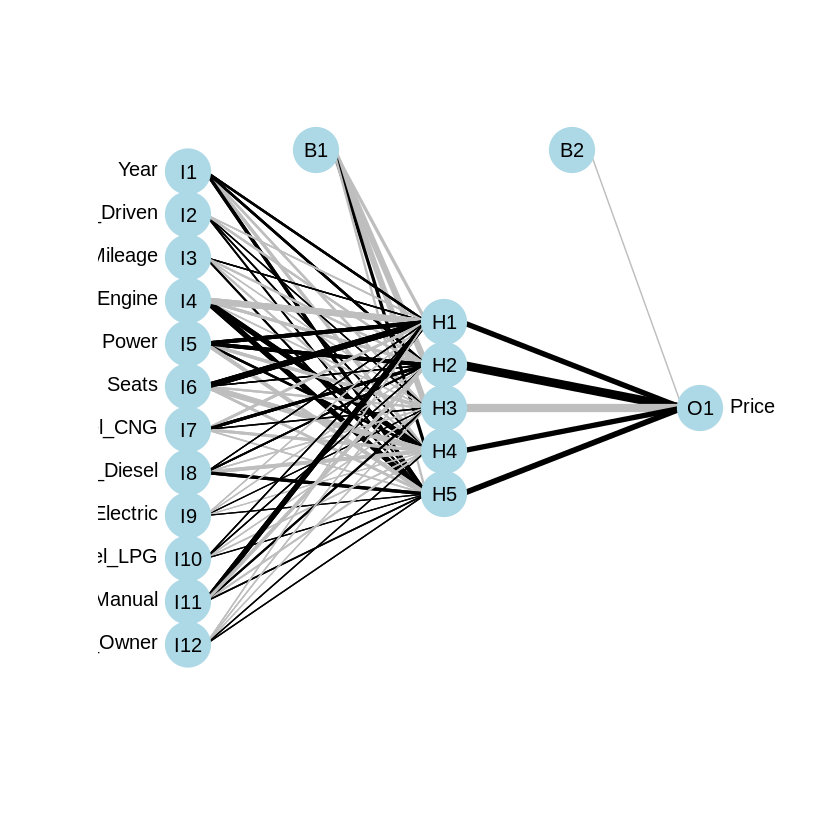

In [ ]:
plotnet(nnet_fit)

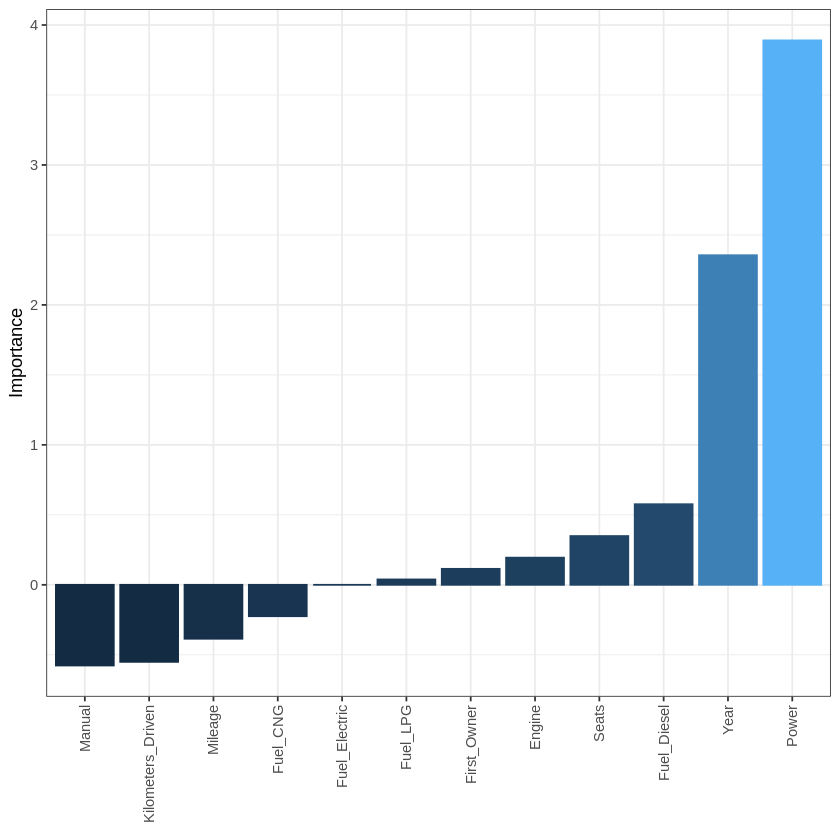

In [ ]:
olden(nnet_fit) + theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

## **DO NOT Fit a Random Forest**

In [ ]:
##set.seed(3333)
##rf_fit <- train(
##        Price ~ . , data = train, method = "rf",
##        trControl = trctrl, na.action = na.omit)       

## Compare Results

In [ ]:
rbind(getTrainPerf(lm_fit), getTrainPerf(knn_fit), getTrainPerf(xgb_fit), getTrainPerf(nnet_fit))

TrainRMSE,TrainRsquared,TrainMAE,method
<dbl>,<dbl>,<dbl>,<chr>
0.3120900,0.8736382,0.2366883,lm
0.2892229,0.8913730,0.2085350,knn
0.2315142,0.9301720,0.1698605,xgbTree
0.2787731,0.8989574,0.2090165,nnet


## RMSE on Test Set

First, we use the `predict()` function to apply our model to the test set. 

In [ ]:
test <- na.omit(test)
test$testPreds <- predict(xgb_fit, test)

Next, we can use the `RMSE()` function from the `MLmetrics` package to calculate the model's accuracy on the test set. 

In [ ]:
RMSE(test$testPreds, test$Price)

[1] 0.2286851

In [ ]:
## Just for fun compare to predictions from the nnet
RMSE(predict(nnet_fit,test), test$Price)

[1] 0.2974553

Finally, let's plot our models predictions against the true values (recall that we are working with logged price). 

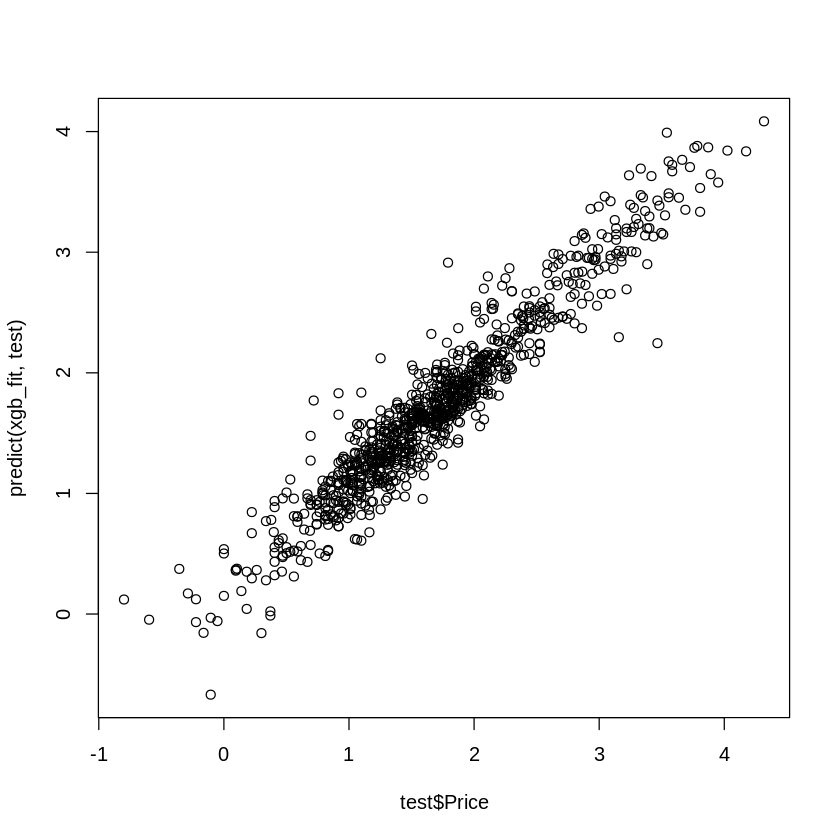

In [ ]:
plot(test$Price, predict(xgb_fit,test))


# **Carvana: IsBadBuy?**

Now let's return to the Carvana data we saw in previous classes, where the goal is to predict whether or not a car is a lemon. 

## **Investigate Data**

In [ ]:
carvana.data <- read_csv("http://www.dsm.business/data/carvana_data_training.csv", na=c("NULL"))
carvana.data <- carvana.data[complete.cases(carvana.data), ]
head(carvana.data)

Rows: 72983 Columns: 34
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (15): PurchDate, Auction, Make, Model, Trim, SubModel, Color, Transmissi...
dbl (19): RefId, IsBadBuy, VehYear, VehicleAge, WheelTypeID, VehOdo, MMRAcqu...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


RefId,IsBadBuy,PurchDate,Auction,VehYear,VehicleAge,Make,Model,Trim,SubModel,⋯,MMRCurrentRetailAveragePrice,MMRCurrentRetailCleanPrice,PRIMEUNIT,AUCGUART,BYRNO,VNZIP1,VNST,VehBCost,IsOnlineSale,WarrantyCost
<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,⋯,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>
276,0,10/4/2010,ADESA,2003,7,HYUNDAI,ACCENT,GL,4D SEDAN GL,⋯,5332,6887,NO,GREEN,5546,33619,FL,4500,0,1054
291,0,10/11/2010,ADESA,2005,5,CHEVROLET,1500 SILVERADO PICKU,Bas,REG CAB 4.3L,⋯,9264,11033,NO,GREEN,19638,33619,FL,7100,0,905
298,0,10/18/2010,ADESA,2006,4,CHEVROLET,EQUINOX FWD V6,LS,4D SUV LS,⋯,11543,13228,NO,GREEN,5546,33619,FL,8950,0,1215
306,0,10/25/2010,ADESA,2004,6,CHRYSLER,PT CRUISER,Bas,4D SEDAN,⋯,6691,7438,NO,GREEN,5546,33619,FL,4600,0,1389
315,0,10/25/2010,ADESA,2002,8,MERCURY,SABLE,LS,4D SEDAN LS PREMIUM,⋯,5816,6883,NO,GREEN,5546,33619,FL,4200,0,1353
322,0,10/25/2010,ADESA,2006,4,PONTIAC,GRAND PRIX,Bas,4D SEDAN,⋯,9367,10952,NO,GREEN,5546,33619,FL,5900,0,2351


Below we randomly split our data into training (80%) and test (20%) sets. 

In [ ]:
set.seed(233434)

# Randomly shuffle the data
carvana.data.shuffled <- carvana.data[sample(nrow(carvana.data)),]

# Define 80% cutoff for the training data
trainCutoff <- round(nrow(carvana.data) * 0.80)

# Randomly split the data into 80% training 20% validation
carvana.train <- carvana.data.shuffled[1:trainCutoff,]
carvana.test <- carvana.data.shuffled[(trainCutoff+1):nrow(carvana.data.shuffled),]

### Set Up $k$-fold Cross Validation

To set this up, we use the `trainControl()` function to create an object called `modelParameters` that will apply five-fold cross validation.

In [ ]:
modelParameters <- trainControl(method = "cv", number = 5, summaryFunction = mnLogLoss, classProbs = TRUE)

Remember that the `caret` package expects the $Y$ variable to be coded as a `character` variable, not a `numeric`. Therefore, we need to convert the coding of `IsBadBuy` to be `"LEMON"` / `"IS_NOT_LEMON"` instead of `1` / `0`. In the cell below, we create a new data frame called `carvanaTrainKFold`, and use `ifelse()` to change the way the variable is recorded.

In [ ]:
# Copy carvana.train into a new data frame, carvanaTrainKFold
carvanaTrainKFold <- carvana.train

# In carvanaTrainKFold, change the coding of IsBadBuy from numeric to character
carvanaTrainKFold$IsBadBuy <- ifelse(carvanaTrainKFold$IsBadBuy==1, "LEMON", "IS_NOT_LEMON")

# Output the first few rows of carvanaTrainKFold
head(carvanaTrainKFold)

RefId,IsBadBuy,PurchDate,Auction,VehYear,VehicleAge,Make,Model,Trim,SubModel,Color,Transmission,WheelTypeID,WheelType,VehOdo,Nationality,Size,TopThreeAmericanName,MMRAcquisitionAuctionAveragePrice,MMRAcquisitionAuctionCleanPrice,MMRAcquisitionRetailAveragePrice,MMRAcquisitonRetailCleanPrice,MMRCurrentAuctionAveragePrice,MMRCurrentAuctionCleanPrice,MMRCurrentRetailAveragePrice,MMRCurrentRetailCleanPrice,PRIMEUNIT,AUCGUART,BYRNO,VNZIP1,VNST,VehBCost,IsOnlineSale,WarrantyCost
<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>
67387,IS_NOT_LEMON,11/3/2010,ADESA,2006,4,HYUNDAI,SONATA 4C,GLS,4D SEDAN GLS,BLUE,AUTO,1,Alloy,51624,OTHER ASIAN,MEDIUM,OTHER,6252,7221,9455,10482,6507,7622,9417,11324,NO,GREEN,52644,77086,TX,8030,0,671
68698,IS_NOT_LEMON,11/18/2010,ADESA,2006,4,HYUNDAI,ELANTRA,GLS,4D SEDAN,BLUE,AUTO,2,Covers,50832,OTHER ASIAN,MEDIUM,OTHER,4509,5479,7944,8880,4888,6098,8362,10043,NO,GREEN,22916,80817,CO,6025,0,505
52332,IS_NOT_LEMON,12/8/2010,MANHEIM,2005,5,DODGE,1500 RAM PICKUP 2WD,SLT,QUAD CAB 4.7L SLT,GREY,AUTO,1,Alloy,80653,AMERICAN,LARGE TRUCK,CHRYSLER,8640,10753,13017,14687,8509,10611,12421,14168,NO,GREEN,25100,78219,TX,10250,0,983
63229,IS_NOT_LEMON,11/23/2010,MANHEIM,2008,2,CHEVROLET,IMPALA V6,LS,4D SEDAN LS 3.5L FFV,GREY,AUTO,2,Covers,68542,AMERICAN,LARGE,GM,7814,8662,11806,12743,8947,10312,12457,13839,NO,GREEN,52598,28625,NC,8145,0,1703
69440,IS_NOT_LEMON,8/6/2010,ADESA,2007,3,CHRYSLER,PT CRUISER,Tou,4D SEDAN,WHITE,AUTO,2,Covers,97312,AMERICAN,MEDIUM,CHRYSLER,5506,6574,8819,9723,6203,7540,9782,11005,NO,GREEN,23359,91752,CA,4570,0,1630
13131,IS_NOT_LEMON,11/22/2010,MANHEIM,2005,5,FORD,TAURUS,SE,4D SEDAN SE FFV,SILVER,AUTO,1,Alloy,99967,AMERICAN,MEDIUM,FORD,4407,5855,7678,9458,3765,5171,6667,8401,NO,GREEN,19619,27542,NC,4730,0,1053


## **Logistic Regression**

Using five-fold cross-validation with logistic regression, build a basic model that predicts whether a given car has a major defect ($\texttt{IsBadBuy} = 1$). 

In [ ]:
set.seed(650718)
model.reg <- train(IsBadBuy ~ Size + TopThreeAmericanName + MMRAcquisitionAuctionAveragePrice, 
                      data = carvanaTrainKFold,
                      method="glm",
                      trControl = modelParameters)

model.reg

Generalized Linear Model 

2706 samples
   3 predictor
   2 classes: 'IS_NOT_LEMON', 'LEMON' 

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 2166, 2165, 2164, 2165, 2164 
Resampling results:

  logLoss  
  0.1852126


## **kNN**

Now use $k$-fold cross validation to fit and evaluate a kNN model. 

In [ ]:
set.seed(650718)
model.knn <- train(IsBadBuy ~ Size + TopThreeAmericanName + MMRAcquisitionAuctionAveragePrice, 
                      data = carvanaTrainKFold,
                      method="knn",
                      preProc = c("center", "scale"),
                      trControl = modelParameters,
                      tuneGrid = data.frame(k = seq(70, 90, by = 1))
)

model.knn

k-Nearest Neighbors 

2706 samples
   3 predictor
   2 classes: 'IS_NOT_LEMON', 'LEMON' 

Pre-processing: centered (15), scaled (15) 
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 2166, 2165, 2164, 2165, 2164 
Resampling results across tuning parameters:

  k   logLoss  
  70  0.2884882
  71  0.2777870
  72  0.2669072
  73  0.2557980
  74  0.2561640
  75  0.2563888
  76  0.2556941
  77  0.2552609
  78  0.2443996
  79  0.2329682
  80  0.2330895
  81  0.2325169
  82  0.2325495
  83  0.2329828
  84  0.2324879
  85  0.2322931
  86  0.2325041
  87  0.2328742
  88  0.2331093
  89  0.2329859
  90  0.2330943

logLoss was used to select the optimal model using the smallest value.
The final value used for the model was k = 85.

## **XGBoost**

In [ ]:
set.seed(650718)
model.XGB <- train(IsBadBuy ~ Size + TopThreeAmericanName + MMRAcquisitionAuctionAveragePrice, 
                      data = carvanaTrainKFold,
                      method="xgbTree",
                      trControl = modelParameters,
                      verbose = FALSE, verbosity = 0
)

model.XGB

eXtreme Gradient Boosting 

2706 samples
   3 predictor
   2 classes: 'IS_NOT_LEMON', 'LEMON' 

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 2166, 2165, 2164, 2165, 2164 
Resampling results across tuning parameters:

  eta  max_depth  colsample_bytree  subsample  nrounds  logLoss  
  0.3  1          0.6               0.50        50      0.1677901
  0.3  1          0.6               0.50       100      0.1693481
  0.3  1          0.6               0.50       150      0.1681547
  0.3  1          0.6               0.75        50      0.1656184
  0.3  1          0.6               0.75       100      0.1677906
  0.3  1          0.6               0.75       150      0.1701688
  0.3  1          0.6               1.00        50      0.1656744
  0.3  1          0.6               1.00       100      0.1670532
  0.3  1          0.6               1.00       150      0.1680034
  0.3  1          0.8               0.50        50      0.1667961
  0.3  1          0.8

In [ ]:
getTrainPerf(model.XGB)

TrainlogLoss,method
<dbl>,<chr>
0.1656184,xgbTree


In [ ]:
getTrainPerf(model.knn)

TrainlogLoss,method
<dbl>,<chr>
0.2322931,knn


In [ ]:
varImp(model.XGB)

xgbTree variable importance

                                  Overall
MMRAcquisitionAuctionAveragePrice 100.000
SizeSMALL SUV                      13.310
TopThreeAmericanNameFORD            5.730
TopThreeAmericanNameGM              5.030
SizeMEDIUM SUV                      4.568
SizeSPORTS                          3.673
SizeVAN                             2.195
TopThreeAmericanNameOTHER           1.820
SizeLARGE TRUCK                     1.438
SizeCROSSOVER                       0.000
SizeMEDIUM                          0.000
SizeSPECIALTY                       0.000
SizeLARGE SUV                       0.000
SizeLARGE                           0.000
SizeSMALL TRUCK                     0.000

## **Neural Network**

In [ ]:
set.seed(650718)
model.nnet <- train(IsBadBuy ~ Size + TopThreeAmericanName + MMRAcquisitionAuctionAveragePrice, 
                      data = carvanaTrainKFold,
                      method="nnet",
                      trControl = modelParameters, 
                      maxit = 1000,
                      tuneGrid = data.frame(size = c(2, 3, 5), decay = 0.5)

)

model.nnet

# weights:  35
initial  value 1799.518411 
iter  10 value 366.201411
iter  20 value 365.617068
iter  30 value 361.656482
iter  40 value 359.250656
final  value 359.194076 
converged
# weights:  52
initial  value 1776.983973 
iter  10 value 366.435936
iter  20 value 366.189870
iter  30 value 364.493116
iter  40 value 362.014682
iter  50 value 359.892900
iter  60 value 357.857841
iter  70 value 357.828026
final  value 357.827587 
converged
# weights:  86
initial  value 2019.206909 
iter  10 value 374.055292
iter  20 value 364.554727
iter  30 value 364.523241
iter  40 value 362.168094
iter  50 value 360.340565
iter  60 value 359.312588
iter  70 value 358.472525
iter  80 value 357.796852
iter  90 value 357.316046
iter 100 value 356.682113
iter 110 value 356.646676
iter 120 value 356.514587
iter 130 value 356.511431
iter 140 value 356.511135
final  value 356.510891 
converged
# weights:  35
initial  value 1400.613897 
iter  10 value 366.266765
iter  20 value 365.917444
iter  30 value 359.53

Neural Network 

2706 samples
   3 predictor
   2 classes: 'IS_NOT_LEMON', 'LEMON' 

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 2166, 2165, 2164, 2165, 2164 
Resampling results across tuning parameters:

  size  logLoss  
  2     0.1652527
  3     0.1653752
  5     0.1667283

Tuning parameter 'decay' was held constant at a value of 0.5
logLoss was used to select the optimal model using the smallest value.
The final values used for the model were size = 2 and decay = 0.5.

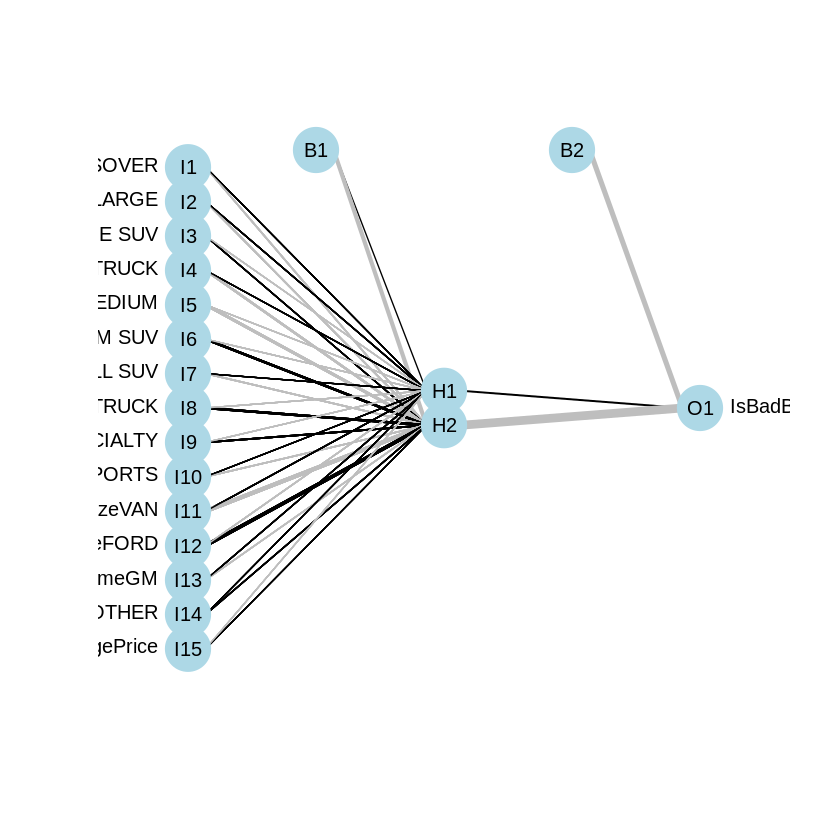

In [ ]:
plotnet(model.nnet)

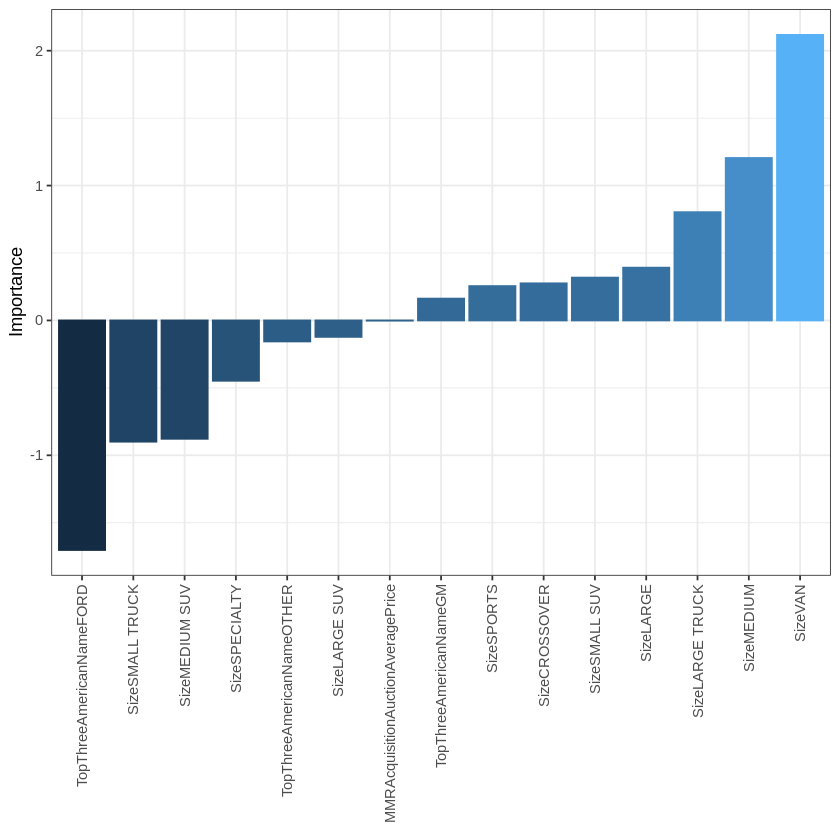

In [ ]:
olden(model.nnet) + theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

## **Log Loss on Test Set**

In [ ]:
LogLoss(predict(model.XGB, carvana.test, type="prob")$LEMON, carvana.test$IsBadBuy)

[1] 0.1501305

In [ ]:
LogLoss(predict(model.nnet, carvana.test, type="prob")$LEMON, carvana.test$IsBadBuy)

[1] 0.1529075

# Model Building with H2O

## Load in the packages

In [ ]:
install.packages(c("h2o","mlbench"))
library(h2o)
library(mlbench)

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘RCurl’



----------------------------------------------------------------------

Your next step is to start H2O:
    > h2o.init()

For H2O package documentation, ask for help:
    > ??h2o

After starting H2O, you can use the Web UI at http://localhost:54321
For more information visit https://docs.h2o.ai

----------------------------------------------------------------------



Attaching package: ‘h2o’


The following objects are masked from ‘package:stats’:

    cor, sd, var


The following objects are masked from ‘package:base’:

    &&, %*%, %in%, ||, apply, as.factor, as.numeric, colnames,
    colnames<-, ifelse, is.character, is.factor, is.numeric, log,
    log10, log1p, log2, round, signif, trunc




## Define Target and Features

In [ ]:
target <- "Price" 
features <- setdiff(colnames(data), target)
print(features)

 [1] "Year"              "Kilometers_Driven" "Mileage"          
 [4] "Engine"            "Power"             "Seats"            
 [7] "Fuel_CNG"          "Fuel_Diesel"       "Fuel_Electric"    
[10] "Fuel_LPG"          "Manual"            "First_Owner"      


## Start a local H2O Cluster (JVM)

In [ ]:
h2o.init()


H2O is not running yet, starting it now...

Note:  In case of errors look at the following log files:
    /tmp/RtmpgV0NTR/file4d7461669e/h2o_UnknownUser_started_from_r.out
    /tmp/RtmpgV0NTR/file4deb32f7a/h2o_UnknownUser_started_from_r.err


Starting H2O JVM and connecting: ..... Connection successful!

R is connected to the H2O cluster: 
    H2O cluster uptime:         3 seconds 298 milliseconds 
    H2O cluster timezone:       Etc/UTC 
    H2O data parsing timezone:  UTC 
    H2O cluster version:        3.38.0.1 
    H2O cluster version age:    2 months and 10 days  
    H2O cluster name:           H2O_started_from_R_root_mzj741 
    H2O cluster total nodes:    1 
    H2O cluster total memory:   3.17 GB 
    H2O cluster total cores:    2 
    H2O cluster allowed cores:  2 
    H2O cluster healthy:        TRUE 
    H2O Connection ip:          localhost 
    H2O Connection port:        54321 
    H2O Connection proxy:       NA 
    H2O Internal Security:      FALSE 
    R Version:   

## Convert R dataframe into H2O dataframe

In [ ]:
# H2O dataframe
h_data <- as.h2o(data)

  |======================================================================| 100%


## Split Data into Train/Test

In [ ]:
n_seed = 1234
h_train <- as.h2o(train)
h_test <- as.h2o(test)

  |======================================================================| 100%
  |======================================================================| 100%


## Baseline Linear Regression

In [ ]:
model_glm <- h2o.glm(x = features,               # All explanatory variables
                     y = target,                 # price of car
                     training_frame = h_train,   # H2O dataframe with training data
                     model_id = "baseline_glm",  # Give the model a name
                     nfolds = 5)                # Using 5-fold CV
                                 
                     
# Cross-Validation
model_glm@model$cross_validation_metrics

  |======================================================================| 100%


H2ORegressionMetrics: glm
** Reported on cross-validation data. **
** 5-fold cross-validation on training data (Metrics computed for combined holdout predictions) **

MSE:  0.1045574
RMSE:  0.3233533
MAE:  0.2426153
RMSLE:  0.1476801
Mean Residual Deviance :  0.1045574
R^2 :  0.8678468
Null Deviance :3976.812
Null D.o.F. :5021
Residual Deviance :525.087
Residual D.o.F. :5010
AIC :2938.045


In [ ]:
# Evaluate performance on test
h2o.performance(model_glm, newdata = h_test)

H2ORegressionMetrics: glm

MSE:  0.1188147
RMSE:  0.3446951
MAE:  0.23175
RMSLE:  NaN
Mean Residual Deviance :  0.1188147
R^2 :  0.7986603
Null Deviance :596.4759
Null D.o.F. :967
Residual Deviance :115.0126
Residual D.o.F. :957
AIC :709.0409


## Baseline Random Forest

In [ ]:
# Baseline Distributed Random Forest (DRF)
model_drf <- h2o.randomForest(x = features,
                              y = target,
                              training_frame = h_train,
                              model_id = "baseline_drf",
                              nfolds = 5,
                              seed = n_seed)
                

  |======================================================================| 100%


In [ ]:
model_drf@model$cross_validation_metrics

H2ORegressionMetrics: drf
** Reported on cross-validation data. **
** 5-fold cross-validation on training data (Metrics computed for combined holdout predictions) **

MSE:  0.06069536
RMSE:  0.2463643
MAE:  0.1729457
RMSLE:  0.1210278
Mean Residual Deviance :  0.06069536


In [ ]:
h2o.performance(model_drf, newdata = h_test)

H2ORegressionMetrics: drf

MSE:  0.0525521
RMSE:  0.2292424
MAE:  0.1652354
RMSLE:  0.1184389
Mean Residual Deviance :  0.0525521


## Baseline Neural Net

In [ ]:
# Baseline Deep Neural Network (DNN)
# By default, DNN is not reproducible with multi-core. You may get slightly different results here.
# You can enable the `reproducible` option but it will run on a single core (very slow).
model_dnn <- h2o.deeplearning(x = features, 
                              y = target, 
                              training_frame = h_train,
                              model_id = "baseline_dnn", 
                              nfolds = 5, 
                              seed = n_seed)

  |======================================================================| 100%


In [ ]:
model_dnn@model$cross_validation_metrics

H2ORegressionMetrics: deeplearning
** Reported on cross-validation data. **
** 5-fold cross-validation on training data (Metrics computed for combined holdout predictions) **

MSE:  0.08108738
RMSE:  0.2847585
MAE:  0.2110162
RMSLE:  0.132168
Mean Residual Deviance :  0.08108738


In [ ]:
h2o.performance(model_dnn, newdata = h_test)

H2ORegressionMetrics: deeplearning

MSE:  0.07788102
RMSE:  0.2790717
MAE:  0.2021867
RMSLE:  0.1329387
Mean Residual Deviance :  0.07788102


## Comparison (RMSE: Lower = Better)

In [ ]:
# Create a table to compare RMSE from different models
d_eval <- data.frame(model = c("H2O GLM: Generalized Linear Model (Baseline)", 
                               "H2O DRF: Distributed Random Forest (Baseline)",
                               "H2O DNN: Deep Neural Network (Baseline)"),                               
                     stringsAsFactors = FALSE)
d_eval$RMSE_cv <- NA
d_eval$RMSE_test <- NA

In [ ]:
# Store RMSE values
d_eval[1, ]$RMSE_cv <- model_glm@model$cross_validation_metrics@metrics$RMSE
d_eval[2, ]$RMSE_cv <- model_drf@model$cross_validation_metrics@metrics$RMSE
d_eval[3, ]$RMSE_cv <- model_dnn@model$cross_validation_metrics@metrics$RMSE

d_eval[1, ]$RMSE_test <- h2o.rmse(h2o.performance(model_glm, newdata = h_test))
d_eval[2, ]$RMSE_test <- h2o.rmse(h2o.performance(model_drf, newdata = h_test))
d_eval[3, ]$RMSE_test <- h2o.rmse(h2o.performance(model_dnn, newdata = h_test))

# Show Comparison (RMSE: Lower = Better)
d_eval

model,RMSE_cv,RMSE_test
<chr>,<dbl>,<dbl>
H2O GLM: Generalized Linear Model (Baseline),0.3233533,0.3446951
H2O DRF: Distributed Random Forest (Baseline),0.2463643,0.2292424
H2O DNN: Deep Neural Network (Baseline),0.2847585,0.2790717


#AutoML with H2O

Automated machine learning, or AutoML, aims to reduce or eliminate the need for skilled data scientists to build machine learning and deep learning models. Instead, an AutoML system allows you to provide the labeled training data as input and receive an optimized model as output.

There are several ways of going about this. One approach is for the software to simply train every kind of model on the data and pick the one that works best. A refinement of this would be for it to build one or more ensemble models that combine the other models, which sometimes (but not always) gives better results.

A second technique is to optimize the hyperparameters (explained below) of the best model or models to train an even better model. Feature engineering (also explained below) is a valuable addition to any model training. One way of de-skilling deep learning is to use transfer learning, essentially customizing a well-trained general model for specific data

In [ ]:
# Run AutoML (try n different models)
# Check out all options using ?h2o.automl
automl = h2o.automl(x = features,
                    y = target,
                    training_frame = h_train,
                    nfolds = 5,                     # 5-fold Cross-Validation
                    max_models = 4,                # Max number of models
                    stopping_metric = "RMSE",       # Metric to optimize
                    project_name = "automl_boston", # Specify a name so you can add more models later
                    seed = n_seed)
                    automl

  |                                                                      |   0%
  |=                                                                     |   1%
  |===                                                                   |   4%
  |====                                                                  |   6%
  |=====                                                                 |   8%
  |=========                                                             |  12%
  |======================================================================| 100%


AutoML Details
Project Name: automl_boston 
Leader Model ID: StackedEnsemble_AllModels_1_AutoML_1_20221129_220355 
Algorithm: stackedensemble 

Total Number of Models Trained: 6 
Start Time: 2022-11-29 22:03:55 UTC 
End Time: 2022-11-29 22:04:23 UTC 
Duration: 27 s

Leaderboard
                                                 model_id      rmse        mse
1    StackedEnsemble_AllModels_1_AutoML_1_20221129_220355 0.2355103 0.05546510
2 StackedEnsemble_BestOfFamily_1_AutoML_1_20221129_220355 0.2407993 0.05798429
3                      XGBoost_2_AutoML_1_20221129_220355 0.2453671 0.06020501
4                      XGBoost_1_AutoML_1_20221129_220355 0.2465739 0.06079870
5                          GBM_1_AutoML_1_20221129_220355 0.2725023 0.07425749
6                          GLM_1_AutoML_1_20221129_220355 0.3233255 0.10453940
        mae     rmsle mean_residual_deviance
1 0.1692992 0.1148288             0.05546510
2 0.1743753 0.1169070             0.05798429
3 0.1774729 0.1182150            

## Best Model (Leader)

In [ ]:
automl@leader

Model Details:

H2ORegressionModel: stackedensemble
Model ID:  StackedEnsemble_AllModels_1_AutoML_1_20221129_220355 
Number of Base Models: 4

Base Models (count by algorithm type):

    gbm     glm xgboost 
      1       1       2 

Metalearner:

Metalearner algorithm: glm
Metalearner cross-validation fold assignment:
  Fold assignment scheme: AUTO
  Number of folds: 5
  Fold column: NULL
Metalearner hyperparameters: 


H2ORegressionMetrics: stackedensemble
** Reported on training data. **

MSE:  0.01855654
RMSE:  0.1362224
MAE:  0.1012406
RMSLE:  0.06776923
Mean Residual Deviance :  0.01855654



H2ORegressionMetrics: stackedensemble
** Reported on cross-validation data. **
** 5-fold cross-validation on training data (Metrics computed for combined holdout predictions) **

MSE:  0.0554651
RMSE:  0.2355103
MAE:  0.1692992
RMSLE:  0.1148288
Mean Residual Deviance :  0.0554651


Cross-Validation Metrics Summary: 
                             mean        sd cv_1_valid cv_2_valid cv_3_vali

## Leader Board (lower is better)

In [ ]:
d_eval_tmp <- data.frame(model = "Best Model from H2O AutoML",
                         RMSE_cv = automl@leader@model$cross_validation_metrics@metrics$RMSE,
                         RMSE_test = h2o.rmse(h2o.performance(automl@leader, newdata = h_test)))
d_eval <- rbind(d_eval, d_eval_tmp)

d_eval

model,RMSE_cv,RMSE_test
<chr>,<dbl>,<dbl>
H2O GLM: Generalized Linear Model (Baseline),0.3233533,0.3446951
H2O DRF: Distributed Random Forest (Baseline),0.2463643,0.2292424
H2O DNN: Deep Neural Network (Baseline),0.2847585,0.2790717
Best Model from H2O AutoML,0.2355103,0.2278306
